In [87]:
import math
import matplotlib.pyplot as plt
import numpy as np

N = 10
K = 100
T = 1
l = np.pi / 2
h = l/N
tau = T/K
sigma = tau/(h ** 2)
x = np.linspace(0,l,N)
t = np.linspace(0,T,K)
Xp, Tp = np.meshgrid(x, t)

print(sigma)
print(tau)
print(h)

0.40528473456935116
0.01
0.15707963267948966


входные функции

In [88]:
def psi(x):
    return 0
def f(x, t):
    return np.cos(x)*(np.cos(t)+np.sin(t))
def phi0(t):
    return np.sin(t)
def phi1(t):
    return -np.sin(t)
def solution(x,t):
    return np.sin(t)*np.cos(x)


точное решение

In [89]:
def analitic(x,t, K):
    u = [0]*K
    for i in range(K):
        u[i] = [0]*N
    for i in range(K):
        for j in range(N):
            u[i][j] = solution(x[j], t[i])
    return u

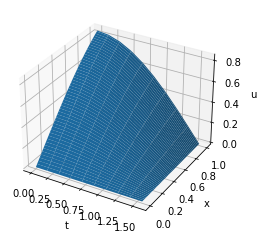

In [90]:
u = analitic(x,t, K)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.plot_surface(Xp,Tp,np.array(u))
plt.show()

явная схема с различными видами апроксимации

In [91]:
def explicit_solve(l, N, K, T, app):
    u = [0]*K
    for i in range(K):
        u[i] = [0]*N
    for j in range(N):
        u[0][j] = psi(j * h)    
    for k in range(K):
        u[k][0] = phi0(tau * k)
#         u[k][-1] = phi1(tau * k)
    
    for k in range(1, K):
        for j in range(1, N-1):
            u[k][j] = u[k-1][j]+tau*(u[k-1][j-1]-2*u[k-1][j]+u[k-1][j+1])/h**2+tau*f(j*h, tau*k)
    if app == 1:
        for k in range(K):
            u[k][-1] = phi1(tau * k)*h + u[k][-2]
    if app == 2:
        for k in range(K):
            u[k][-1] = (phi1(k * tau) * 2 * h - u[k][-3] + 4 * u[k][-2]) / 3
    if app == 3:
        for k in range(K):
            u[k][-1] = (phi1(k * tau) + u[k][-2] / h + 2 * tau * u[k - 1][-1] / h) / (1 / h + 2 * tau / h)
    return u

(двухточечная аппроксимация первого порядка)

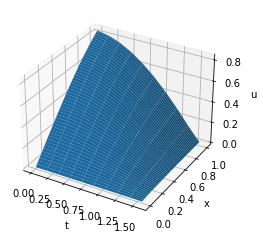

In [92]:
exp1 = explicit_solve(l, N, K, T, 1)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.plot_surface(Xp, Tp, np.array(exp1))
plt.show()

трехточечная аппроксимация со вторым порядком

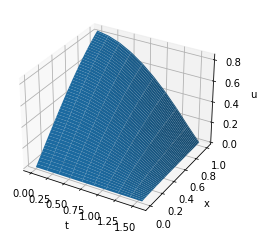

In [93]:
exp2 = explicit_solve(l, N, K, T, 2)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.plot_surface(Xp, Tp, np.array(exp2))
plt.show()

двухточечная аппроксимация со вторым порядком

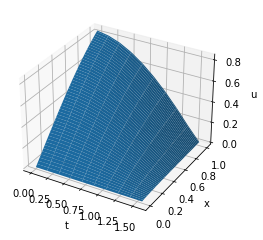

In [94]:
exp3 = explicit_solve(l, N, K, T, 3)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.plot_surface(Xp, Tp, np.array(exp3))
plt.show()

In [95]:
def tma(a, b, c, d):
    n = len(a)
    p, q = [], []
    p.append(-c[0] / b[0])
    q.append(d[0] / b[0])
    for i in range(1, n):
        p.append(-c[i] / (b[i] + a[i] * p[i - 1]))
        q.append((d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1]))
    x = [0 for _ in range(n)]
    x[n - 1] = q[n - 1]
    for i in range(n-2, -1, -1):
        x[i] = p[i] * x[i+1] + q[i]
    return x

неявная схема

In [96]:
def implicit_solve(l, N, K, T):
    sigma = tau / (h ** 2)
    a = np.zeros(N)
    b = np.zeros(N)
    c = np.zeros(N)
    d = np.zeros(N)
    u = [0]*K
    for i in range(K):
        u[i] = [0]*N
    for j in range(N):
        u[0][j] = psi(j * h)
    for k in range(K):
        u[k][0] = phi0(tau*k) 
    for k in range(1, K):
        a[0] = 0
        b[0] = -(1 + 2 * sigma)
        c[0] = sigma
        d[0] = -u[k-1][0]-sigma*phi0((k)*tau)
        for j in range(1, N):
            a[j] = sigma
            b[j] = -(1 + 2 * sigma)
            c[j] = sigma
            d[j] = -u[k-1][j] - tau * f(j * h, (k-1) * tau)
        a[-1] = sigma
        b[-1] = -(1 + 2 * sigma)
        c[-1] = 0
        d[-1] = -h*phi1(tau*(k))*h-u[k][-1]-tau*f(N*h,tau*(k+1))
        u[k] = tma(a, b, c, d)
    return u

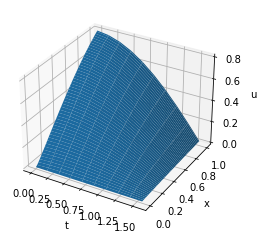

In [97]:
imp = implicit_solve(l, N, K, T)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.plot_surface(Xp, Tp, np.array(imp))
plt.show()

Схема Кранка-Николсона (смешанная)

In [98]:
def crank_nicholson_solve(l, N, K, T):
    tetta = 0.5
    u = np.zeros((K, N))
    imp = implicit_solve(l, N, K, T)
    exp = explicit_solve(l, N, K, T, 1)
    for k in range(0, K):
        for i in range(N):
            u[k][i] = imp[k][i] * tetta + exp[k][i] * (1 - tetta)
    return u

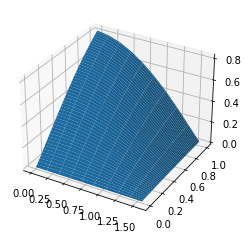

In [99]:
kn = crank_nicholson_solve(l, N, K, T)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(Xp, Tp, np.array(kn))
plt.show()

среднеквадратические ошибки (явная, неявная и смешанная схемы)

In [100]:
def pogr(res, u):
    return math.sqrt(sum([sum([(u[i][j]-res[i][j])**2 for j in range(len(x))]) for i in range(len(t))]))

In [101]:
pogr(exp1, u)

0.24007206456321856

In [102]:
pogr(imp, u)

0.5802814484493348

In [103]:
pogr(kn, u)

0.39054545119420625